In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bert_score import score
from rouge_score import rouge_scorer
from transformers import AutoTokenizer
from typing import List

C:\Users\tomca\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preprocessing

In [2]:
original_articles = pd.read_csv('original_articles.csv', delimiter=';')
generated_articles = pd.read_csv('generated_articles.csv', delimiter=';')
llm_as_judge_scores = pd.read_csv('llm_as_judge_scores.csv')

Calculate bert, rouge1, rouge2, rougeL score for each article and save each value in dictionary for further use.

In [3]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
sections = ['Headline', 'Perex', 'Article']
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Dictionary for scores for each article
all_scores = {section: {'bert': [], 'rouge1': [], 'rouge2': [], 'rougeL': [], 'llm_as_judge': [], 'token_length_ratio': []} for section in sections}
# Calculate and save the scores
for section in sections:
    references = original_articles[section].dropna().tolist()
    hypotheses = generated_articles[section].dropna().tolist()

    # Compute BERTScore
    P, R, F1 = score(hypotheses, references, lang="en", rescale_with_baseline=False)
    all_scores[section]['bert'] = F1.tolist()

    # Compute ROUGE scores
    rouge_scores = [scorer.score(h, r) for h, r in zip(hypotheses, references)]
    all_scores[section]['rouge1'] = [r['rouge1'].fmeasure for r in rouge_scores]
    all_scores[section]['rouge2'] = [r['rouge2'].fmeasure for r in rouge_scores]
    all_scores[section]['rougeL'] = [r['rougeL'].fmeasure for r in rouge_scores]

    # Compute token-length ratio reference vs hypotheses
    token_lengths_hypothesis = [len(tokenizer.tokenize(h)) for h in hypotheses]
    token_lengths_reference = [len(tokenizer.tokenize(r)) for r in references]
    token_length_ratios = [
        h_len / r_len if r_len > 0 else 0
        for h_len, r_len in zip(token_lengths_hypothesis, token_lengths_reference)
    ]
    all_scores[section]['token_length_ratio'] = token_length_ratios

all_scores['Headline']['llm_as_judge'] = llm_as_judge_scores['Headline'].tolist()
all_scores['Perex']['llm_as_judge'] = llm_as_judge_scores['Perex'].tolist()
all_scores['Article']['llm_as_judge'] = llm_as_judge_scores['Article'].tolist()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (856 > 512). Running this 

# Mean scores for sections

In [4]:
# Calculate mean scores
results = {
    'Section': [], 'Mean BERTScore': [], 'Mean ROUGE-1': [], 'Mean ROUGE-2': [], 'Mean ROUGE-L': [], 'Mean LLM as judge': [], 'Mean token length ratio': []
}
for section in sections:
    results['Section'].append(section)
    results['Mean BERTScore'].append(np.mean(all_scores[section]['bert']))
    results['Mean ROUGE-1'].append(np.mean(all_scores[section]['rouge1']))
    results['Mean ROUGE-2'].append(np.mean(all_scores[section]['rouge2']))
    results['Mean ROUGE-L'].append(np.mean(all_scores[section]['rougeL']))
    results['Mean LLM as judge'].append(np.mean(all_scores[section]['llm_as_judge']))
    results['Mean token length ratio'].append(np.mean(all_scores[section]['token_length_ratio']))



In [5]:
results_df = pd.DataFrame(results)
results_df

,Section,Mean BERTScore,Mean ROUGE-1,Mean ROUGE-2,Mean ROUGE-L,Mean LLM as judge,Mean token length ratio
0,Headline,0.814561,0.172511,0.045785,0.141371,0.229167,1.312229
1,Perex,0.816422,0.200721,0.061714,0.152016,0.309167,1.452223
2,Article,0.850981,0.415212,0.169284,0.214153,0.738333,1.107761


# Calculate tag accuracy
This metric does not completely reflect the reality of correctly generated tags. For example, generated tags are missing spaces between words as well as diacritic. You can also see that sometimes it generates a synonym tags compared to the original or adds additional word into the tag. In these scenarios the tags have the same meaning, but will be evaluated as incorrect.

In [6]:
valid_rows = original_articles["Tags"].notna() & (original_articles["Tags"] != "N/A")

# Now, filter both references (original_articles) and hypotheses (generated_articles) based on valid rows
references = original_articles["Tags"][valid_rows]
hypotheses = generated_articles["Tags"][valid_rows]

correct_count = 0
total_count = 0

for ref, hyp in zip(references, hypotheses):
    # Transform references to lowercase and split by comma
    ref_tags = {tag.strip().lower() for tag in ref.split(',')}
    # Split hypotheses by space and convert to set
    hyp_tags = {tag.strip().lower() for tag in hyp.split()}

    print(f"ref: {ref_tags}\nhyp: {hyp_tags}")

    # For each tag in the hypothesis, check if it exists in the references
    for tag in hyp_tags:
        if tag in ref_tags:
            correct_count += 1
        total_count += 1

# Calculate the tag accuracy
tag_accuracy = correct_count / total_count if total_count > 0 else 0
print(f"\nTag accuracy metric: {tag_accuracy}")

ref: {'#infraštruktúra', '#stavebníctvo', '#stavebná produkcia', '#štatistický úrad'}
hyp: {'#rok2024', '#infraštruktúra', '#slovenskostavebníctvo', '#stavebnáprodukcia'}
ref: {'#pohonné látky', '#štatistický úrad', '#benzín'}
hyp: {'#cenypohonnychlatok', '#benzin', '#ekologickepaliva', '#nafta'}
ref: {'#potraviny', '#ceny potravín'}
hyp: {'#cenovéhladiny', '#eú', '#potraviny', '#slovensko'}
ref: {'#potraviny', '#ceny potravín', '#dph', '#konsolidácia'}
hyp: {'#inflácia', '#potraviny', '#ceny', '#slovensko'}
ref: {'#platy', '#inflácia'}
hyp: {'#priemernamzda', '#statistiky', '#regionalnerozdiely', '#ekonomikaslovenska'}
ref: {'#výstavba bytov', '#nájomné bývanie', '#výstavba', '#byty'}
hyp: {'#statistiky', '#vystavba', '#regionalnerozdiely', '#byty'}
ref: {'#inflácia na slovensku', '#zdražovanie', '#ceny potravín'}
hyp: {'#statistiky', '#mzdy', '#reaze', '#inflacia'}
ref: {'#platy', '#inflácia'}
hyp: {'#inflácia', '#potraviny', '#ceny', '#spotrebitelskéceny'}
ref: {'#chudoba', '#mzda',

# Plotting the score distribution of the different score types across section through histogram.

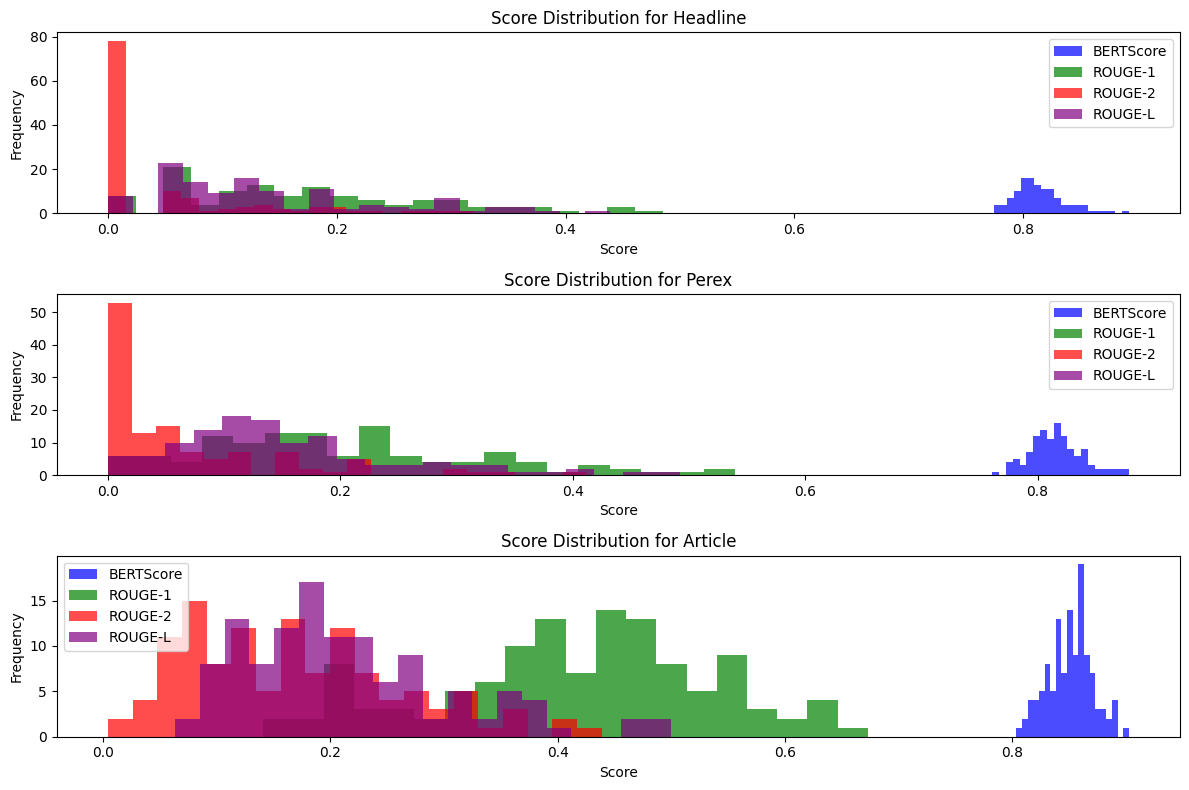

In [7]:
plt.figure(figsize=(12, 8))
for i, section in enumerate(sections):
    plt.subplot(3, 1, i+1)
    plt.hist(all_scores[section]['bert'], bins=20, alpha=0.7, label='BERTScore', color='blue')
    plt.hist(all_scores[section]['rouge1'], bins=20, alpha=0.7, label='ROUGE-1', color='green')
    plt.hist(all_scores[section]['rouge2'], bins=20, alpha=0.7, label='ROUGE-2', color='red')
    plt.hist(all_scores[section]['rougeL'], bins=20, alpha=0.7, label='ROUGE-L', color='purple')
    #plt.hist(all_scores[section]['llm_as_judge'], bins=20, alpha=0.7, label='LLM as judge', color='yellow')
    plt.title(f'Score Distribution for {section}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

# Boxplots of score types to showcase comparison of how well we did in different sections.

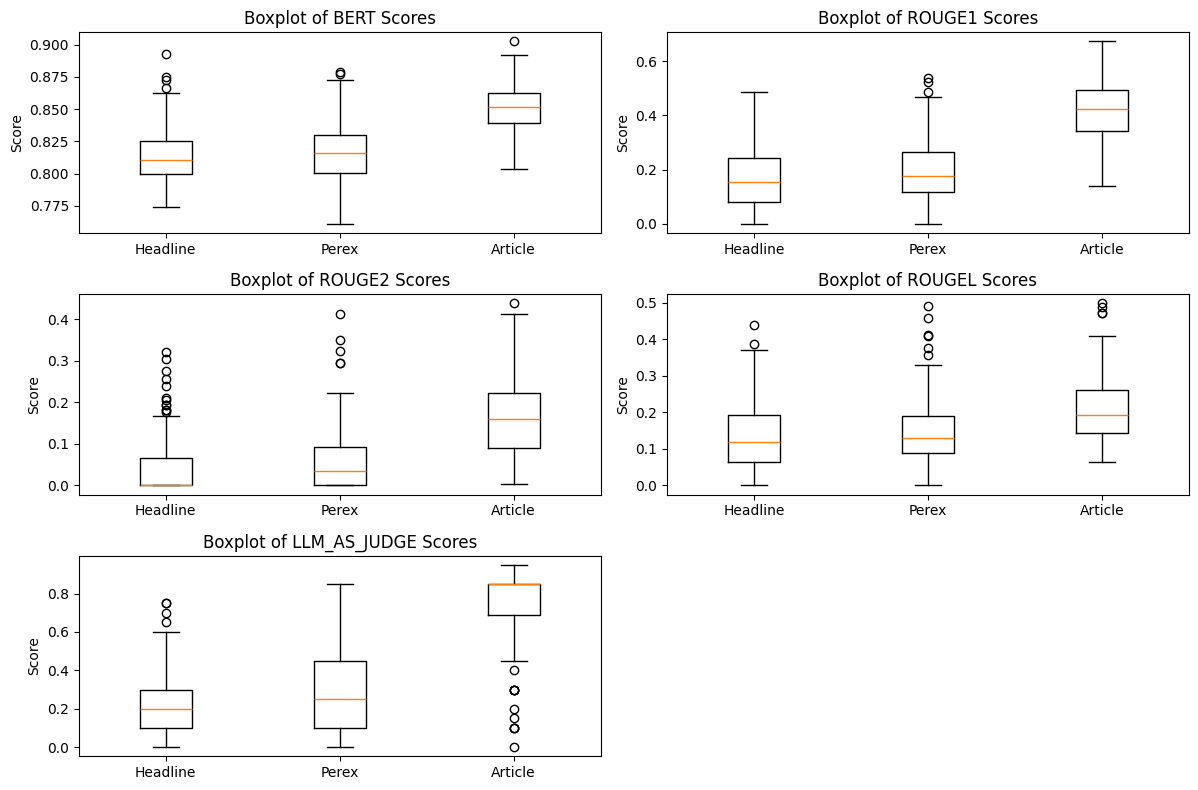

In [8]:
plt.figure(figsize=(12, 8))
for i, metric in enumerate(['bert', 'rouge1', 'rouge2', 'rougeL', 'llm_as_judge']):
    plt.subplot(3, 2, i+1)
    plt.boxplot([all_scores[section][metric] for section in sections], tick_labels=sections)
    plt.title(f'Boxplot of {metric.upper()} Scores')
    plt.ylabel('Score')
plt.tight_layout()
plt.show()


# Aggregated scores for each news site

In [9]:
# Min-Max Scale function for Token Length Ratio
def min_max_scale(values: List[float]) -> List[float]:
    min_val, max_val = np.min(values), np.max(values)
    return [(v - min_val) / (max_val - min_val) if max_val > min_val else 0 for v in values]

# Compute min-max scaled token length ratios for each section
token_length_ratios = {
    section: min_max_scale(all_scores[section]['token_length_ratio'])
    for section in ['Headline', 'Perex', 'Article']
}

In [10]:
concat_articles = pd.concat([original_articles, generated_articles], ignore_index=True)

# Compute mean scores for each news site
news_site_results = concat_articles.groupby('News Site').apply(lambda df: pd.Series({
    # Headline Scores
    'Mean_BERTScore_Headline': np.mean([all_scores['Headline']['bert'][i] for i in df.index if i < len(all_scores['Headline']['bert'])]),
    'Mean_ROUGE_1_Headline': np.mean([all_scores['Headline']['rouge1'][i] for i in df.index if i < len(all_scores['Headline']['rouge1'])]),
    'Mean_ROUGE_2_Headline': np.mean([all_scores['Headline']['rouge2'][i] for i in df.index if i < len(all_scores['Headline']['rouge2'])]),
    'Mean_ROUGE_L_Headline': np.mean([all_scores['Headline']['rougeL'][i] for i in df.index if i < len(all_scores['Headline']['rougeL'])]),
    'Mean_LLM_as_judge_Headline': np.mean([all_scores['Headline']['llm_as_judge'][i] for i in df.index if i < len(all_scores['Headline']['llm_as_judge'])]),

    # Perex Scores
    'Mean_BERTScore_Perex': np.mean([all_scores['Perex']['bert'][i] for i in df.index if i < len(all_scores['Perex']['bert'])]),
    'Mean_ROUGE_1_Perex': np.mean([all_scores['Perex']['rouge1'][i] for i in df.index if i < len(all_scores['Perex']['rouge1'])]),
    'Mean_ROUGE_2_Perex': np.mean([all_scores['Perex']['rouge2'][i] for i in df.index if i < len(all_scores['Perex']['rouge2'])]),
    'Mean_ROUGE_L_Perex': np.mean([all_scores['Perex']['rougeL'][i] for i in df.index if i < len(all_scores['Perex']['rougeL'])]),
    'Mean_LLM_as_judge_Perex': np.mean([all_scores['Perex']['llm_as_judge'][i] for i in df.index if i < len(all_scores['Perex']['llm_as_judge'])]),

    # Article Scores
    'Mean_BERTScore_Article': np.mean([all_scores['Article']['bert'][i] for i in df.index if i < len(all_scores['Article']['bert'])]),
    'Mean_ROUGE_1_Article': np.mean([all_scores['Article']['rouge1'][i] for i in df.index if i < len(all_scores['Article']['rouge1'])]),
    'Mean_ROUGE_2_Article': np.mean([all_scores['Article']['rouge2'][i] for i in df.index if i < len(all_scores['Article']['rouge2'])]),
    'Mean_ROUGE_L_Article': np.mean([all_scores['Article']['rougeL'][i] for i in df.index if i < len(all_scores['Article']['rougeL'])]),
    'Mean_LLM_as_judge_Article': np.mean([all_scores['Article']['llm_as_judge'][i] for i in df.index if i < len(all_scores['Article']['llm_as_judge'])]),
})).reset_index()

C:\Users\tomca\AppData\Local\Temp\ipykernel_14384\236698551.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  news_site_results = concat_articles.groupby('News Site').apply(lambda df: pd.Series({


In [11]:
news_site_results

,News Site,Mean_BERTScore_Headline,Mean_ROUGE_1_Headline,Mean_ROUGE_2_Headline,Mean_ROUGE_L_Headline,Mean_LLM_as_judge_Headline,Mean_BERTScore_Perex,Mean_ROUGE_1_Perex,Mean_ROUGE_2_Perex,Mean_ROUGE_L_Perex,Mean_LLM_as_judge_Perex,Mean_BERTScore_Article,Mean_ROUGE_1_Article,Mean_ROUGE_2_Article,Mean_ROUGE_L_Article,Mean_LLM_as_judge_Article
0,DennikN,0.816256,0.191013,0.053954,0.155071,0.2700,0.826484,0.243061,0.092718,0.187602,0.4500,0.847523,0.340527,0.125934,0.184750,0.6725
1,Forbes,0.816363,0.191643,0.067802,0.157379,0.2650,0.826549,0.270109,0.104552,0.208083,0.3875,0.853129,0.409744,0.151341,0.215659,0.7675
2,Pravda,0.818741,0.159487,0.028730,0.114840,0.2225,0.815521,0.205215,0.063696,0.141806,0.3950,0.840052,0.352996,0.132710,0.160536,0.7000
3,SME,0.811265,0.157651,0.046729,0.136016,0.2200,0.802670,0.112912,0.026530,0.093869,0.1850,0.846577,0.427039,0.161909,0.203490,0.7475
4,Teraz.sk,0.813832,0.206575,0.065531,0.182260,0.1625,0.816913,0.200979,0.038683,0.146947,0.1875,0.855536,0.465121,0.227733,0.251687,0.7200
5,Trend,0.810911,0.128698,0.011964,0.102660,0.2350,0.810394,0.172048,0.044102,0.133790,0.2500,0.863072,0.495846,0.216079,0.268797,0.8225


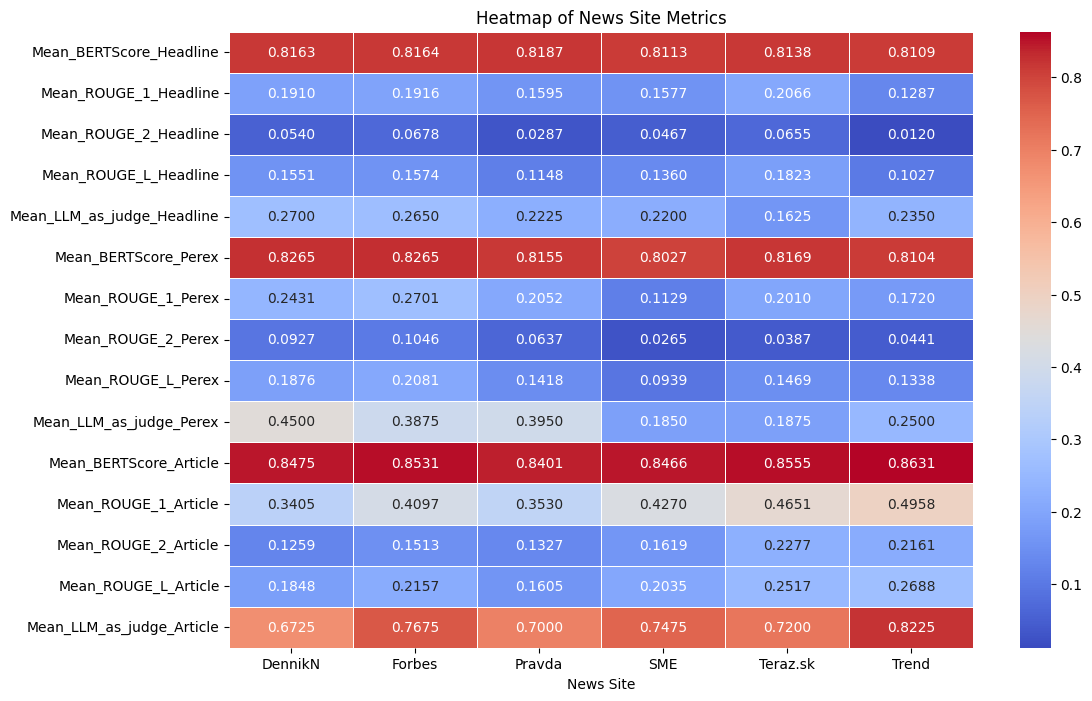

In [12]:
news_site_results_transposed = news_site_results.set_index('News Site').T

plt.figure(figsize=(12, 8))
sns.heatmap(news_site_results_transposed, annot=True, cmap='coolwarm', fmt='.4f', linewidths=0.5)
plt.title('Heatmap of News Site Metrics')
plt.show()

In [13]:
news_sites_token_length = concat_articles.groupby('News Site').apply(lambda df: pd.Series({
'Mean_Token_Length_Ratio_Headline': np.mean([all_scores['Headline']['token_length_ratio'][i] for i in df.index if i < len(all_scores['Headline']['token_length_ratio'])]),
'Mean_Token_Length_Ratio_Perex': np.mean([all_scores['Perex']['token_length_ratio'][i] for i in df.index if i < len(all_scores['Perex']['token_length_ratio'])]),
'Mean_Token_Length_Ratio_Article': np.mean([all_scores['Article']['token_length_ratio'][i] for i in df.index if i < len(all_scores['Article']['token_length_ratio'])]),
})).reset_index()
news_sites_token_length

C:\Users\tomca\AppData\Local\Temp\ipykernel_14384\869701471.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  news_sites_token_length = concat_articles.groupby('News Site').apply(lambda df: pd.Series({


,News Site,Mean_Token_Length_Ratio_Headline,Mean_Token_Length_Ratio_Perex,Mean_Token_Length_Ratio_Article
0,DennikN,1.232965,0.711061,2.315663
1,Forbes,1.175753,1.038713,0.882334
2,Pravda,1.065959,0.461018,0.535660
3,SME,1.473046,3.291152,0.796929
4,Teraz.sk,1.545533,1.240516,1.306699
5,Trend,1.380120,1.970880,0.809282


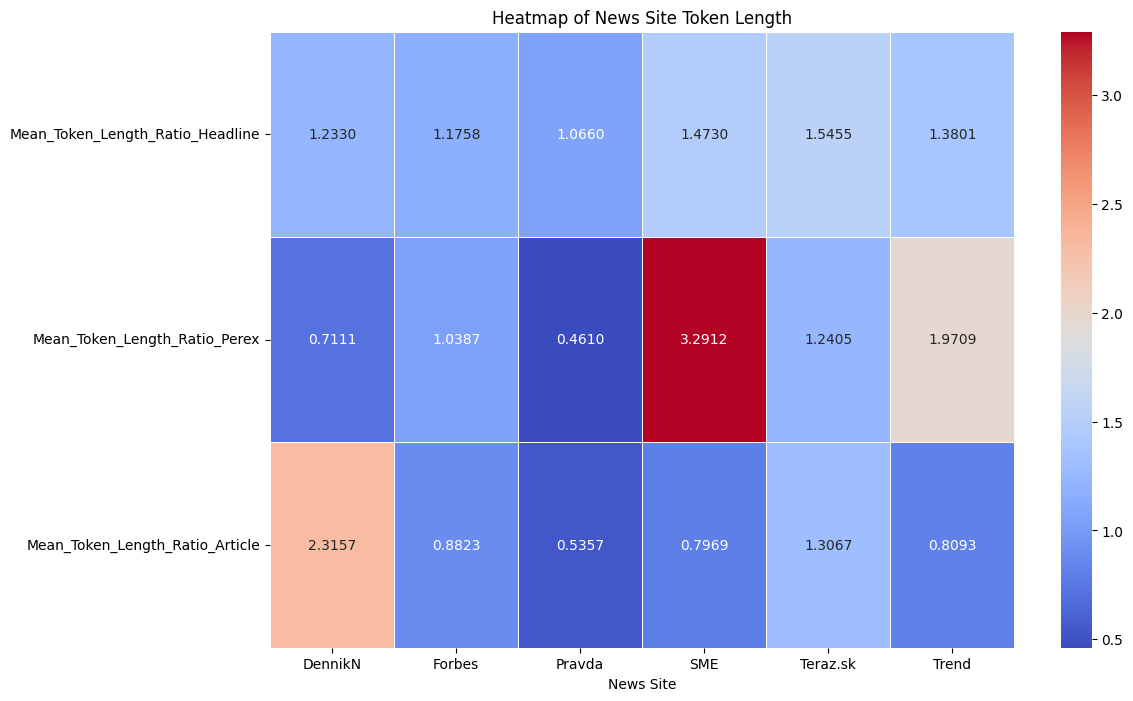

In [14]:
news_site_token_lengths_transposed = news_sites_token_length.set_index('News Site').T

plt.figure(figsize=(12, 8))
sns.heatmap(news_site_token_lengths_transposed, annot=True, cmap='coolwarm', fmt='.4f', linewidths=0.5)
plt.title('Heatmap of News Site Token Length')
plt.show()